# Control Systems Project 
## Object-Tracking using Opencv
##### Alaa Mohamed Roshdy
##### Mohamed Adham Mahrous

## I. Overview

The main aim of this project is to create a feedback control system. Our project is about object tracking. A camera is fixed on a motor, and the camera detects the object in front of it and adjusts its own angle until the object is in the center of the camera. In the closed loop system, the camera is the input and the feedback system simultaneously. This is because the camera is taking the object’s position relative to the center to calculate the relative angle between the center of the object and the center of the camera as the input. It also is the feedback since it calculates how far away the object is from the center of the camera after the camera’s movement (the error). In real-time, the camera should be continuously adjusting itself to follow the object. We also added exponential moving average filter (1st order) to smoothen the noise coming from the processing of the video frames. Shown below are the open loop and closed loop block diagrams.  
![pic](block.png)

## II. Setup 
For our setup, we used a DC motor, with a 1080HD camera mounted on it. We coded the program in Python 3.6.7, using OpenCV 4.0 library for the image processing operations. We used an arduino uno connected to a driver motor (H-bridge) and the DC motor to upload and run our code on. Python and arduino C code were communicating serially. As for the object being tracked, we simply used a bottle cap painted in black with a stick attached to it.


## III. Analysis
In our model the main contributing block is the DC motor, it can be modeled as a second order system as stated in [1]. We are not aiming to get the exact values as we expect more errors to interfere with our model. Also, as we outlines in the block diagram we have a Low-Pass Filter from using an Exponential Moving Average. It’s formula is as follows:
$$y[n]  = \beta x[n] + (1-\beta)y[n-1]$$
Which is a first order IIR filter, and thus should introduce another pole to the system. We expect the other components such as the camera and the image processing and the communication modules to introduce only steady-state errors and not poles.

In [11]:
import cv2 # For image processing and computer vision
import numpy as np # for all numerical computations
import serial # For serial communications with arduino
import struct # For formatting numbers to bytestrings
import seaborn # For plotting
import pickle # For saving the array of results object
from matplotlib import pyplot as plt # For plotting
from scipy.optimize import curve_fit
from scipy.signal import TransferFunction
%matplotlib inline 

In [26]:
import sys
import scipy
import matplotlib
print("Python Version:",sys.version)
print("OpenCV Version:",cv2.__version__)
print("SciPy Version:",scipy.__version__)
print("NumPy Version:",scipy.__version__)
print("Matplotlib Version:",matplotlib.__version__)
print("Seaborn Version:",seaborn.__version__)
print("PySerial Version:",serial.__version__)

Python Version: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
OpenCV Version: 4.0.0
SciPy Version: 1.2.1
NumPy Version: 1.2.1
MatPlotLib Version: 3.0.3
Seaborn Version: 0.9.0
PySerial Version: 3.4


## IV. Procedure
* ### Image transformation
In the camera and the image processing part, we started by connecting the Camera with OpenCV in python. Afterwards, we designed the processing pipeline for the incoming frames. First, we convert the image to grayscale, followed by that we binarize the image. We set the threshold for the binarization according to the object relative to its background. In our case it was black with a light background and thus we set the threshold nearer to 0 than 255. 
Code:
    ```python
    cap = cv2.VideoCapture(0) # get cam feed
    #=============
    ret, frame = cap.read() # Read Frame
    #=============
    ## Transform
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
     _, threshold = cv2.threshold(gray, 70, 255, cv2.THRESH_BINARY)
    ```

* ### Object detection
We then use OpenCV to find all the contours in the binary image (using the edges). We pick the contour that is closest to a circle as we are using a circular object. The criterion on which we choose is:
$$min_{contour_i}|1 - \frac{Area_{contour_i}}{Area_{Minimum Enclosing Circle_i}}|$$
Code:
```python
def get_min_area_over_circ_area(contours):
    '''
    Gets the contour that minimizes |1- (area of contour)/(area of the minimum enclosing circle)|
    '''
    best_diff = 1000 # a large value 
    best_contour = None # will hold the best contour
    for contour in contours:
        area = cv2.contourArea(contour)
        (_,_),radius = cv2.minEnclosingCircle(contour)
        area_circle = np.pi*(radius**2)  
        current_diff = np.abs(1-area/area_circle)
        if current_diff< best_diff :
            best_diff = current_diff
            best_contour = contour
    return best_contour
```
This selection process succeeds in almost all of the frames. Up till now we can detect the object and know its centre’s location. 

In [3]:
def get_min_area_over_circ_area(contours):
    '''
    Gets the contour that minimizes |1- (area of contour)/(area of the minimum enclosing circle)|
    '''
    best_diff = 1000 # a large value 
    best_contour = None # will hold the best contour
    for contour in contours:
        area = cv2.contourArea(contour)
        (_,_),radius = cv2.minEnclosingCircle(contour)
        area_circle = np.pi*(radius**2)  
        current_diff = np.abs(1-area/area_circle)
        if current_diff< best_diff :
            best_diff = current_diff
            best_contour = contour
    return best_contour

* ### Location to angle mapping
We next wanted to map the object’s centre location to angle we want to deviate the camera with. By manual measurements we found that the field of view angle of the webcam is 50 degrees. Then we calculated focal length using the following equation from 1 : 
$$f = \frac{w}{2} cot (\frac{\alpha}{2})$$
code: 
```python
def get_focal_length(width = 640, w_fov = 50 ):
    '''
    Generic Function to calculate approximately 
    Focal Length of camera based on its width (in pixels)
    Input: width in pixels
           w_fov width field of view in pixels
    Output: f focal length in pixels
    '''
    fov= w_fov*np.pi/180
    f = width/2 /np.tan(fov/2)
    return f
```
Where  is the field of view angle and w is the width in pixels. After knowing the focal length we can now map the distance of the object from the centre pixel $\Delta w$ to a change in angle $\Delta \theta$  using the following equation: 
$$\Delta \theta = arctan(\frac{\Delta w}{f})$$
code:
```python
def get_angle_dw(dw,f):
    '''
    Get the angle between the centre pixel and point.
    Input: dw (change in width relative to centre) pixels
           f focal length of camera in pixels
    Output: d_theta angular deviation in degrees
    '''
    return np.arctan(dw/f)*180/np.pi   
```
![](focal-length-fov-sensor-size.jpg)

In [2]:
def get_focal_length(width = 640, w_fov = 50 ):
    '''
    Generic Function to calculate approximately 
    Focal Length of camera based on its width (in pixels)
    Input: width in pixels
           w_fov width field of view in pixels
    Output: f focal length in pixels
    '''
    fov= w_fov*np.pi/180
    f = width/2 /np.tan(fov/2)
    return f
f = get_focal_length() # Get the focal length
def get_angle_dw(dw,f):
    '''
    Get the angle between the centre pixel and point.
    Input: dw (change in width relative to centre) pixels
           f focal length of camera in pixels
    Output: d_theta angular deviation in degrees
    '''
    return np.arctan(dw/f)*180/np.pi   

* ### Collecting Readings:
On each frame we get we collect a reading. However, as there might be errors from faulty readings and sharp transitions. We apply exponential moving average whose formula is described in the previous section. This average has a smoothing effect and is effectively a low-pass filter. This reading procedure is continuously running as we are processing or sending values to the microcontroller.
EMA code: 
```python
def exp_mov_avg(reading, arr, l = 3 ):
    '''
    Exponential moving average to smooth the readings from camera and remove wrong readings
    '''
    beta = 2/(1+l)
    if len(arr)<l:
        return np.mean(arr+[reading])
    return reading*beta + arr[-1]*(1-beta)
```

In [4]:
def exp_mov_avg(reading, arr, l = 3 ):
    '''
    Exponential moving average to smooth the readings from camera and remove wrong readings
    '''
    beta = 2/(1+l)
    if len(arr)<l:
        return np.mean(arr+[reading])
    return reading*beta + arr[-1]*(1-beta)

In [ ]:
#Capture the second webcam in your system
cap = cv2.VideoCapture(0) 

In [5]:
# fps = cap.get(cv2.CAP_PROP_FPS) # 30 fps
fps = 30 

In [ ]:
ser = serial.Serial('/dev/ttyACM0', 115200, timeout=1) # Connect to Arduino's Serial

* ## Step Input
The step input in our system is modeled as moving the object from the centre of the image to its edge with a constant value. We achieved that by waiting for 150 frames until we adjust our object at the edge manually.
* ### Communicating with microcontroller
We then convert this input into a one byte signed int and send serially to our microcontroller (Arduino Uno). This stage is one area of improvement to be addressed in the next stage to lower the quantization errors by using more bits in communicating with the microcontroller.
code: 
```python
ser.write(struct.pack('!b',int(readings[-1]))) 
```
* ## Mapping voltage input to angles in DC motor
To map the motor’s voltage to angles, we fixated the voltage input to the motor to 12 volts, and varied the duration of that input volt given to the motor to calculate the resulting angle of deviation. With trial and error, we mapped an approximate proportional constant between the duration of the input voltage and our angle. We are not paying much attention to this part as there are many sources of error and we expect our controller to fix these errors. After we get this mapping we programmed the arduino to wait for the byte sent from our python code and we rotate the motor. 
C code: 
Check Appendix in cell before last

In [ ]:
readings = [] # Array that holds the readings
while True:
    #Ret will be true if there is a feed, and the frame
    ret, frame = cap.read() # Read Frame
    if ret:
        #Convert color of the frame from BGR to gray
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #any value below 70 will be black, any value above will be white.
        _, threshold = cv2.threshold(gray, 70, 255, cv2.THRESH_BINARY)
        # Get all contours from binary image
        contours,hierarchy = cv2.findContours(threshold, 1, 2)
        # Convert the colot space to RGB to draw the generated contour
        gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        # Get the Most Circular contour which is our object
        contour = get_min_area_over_circ_area(contours)
        # Draw the contour on the image in green
        cv2.drawContours(gray, contour, -1, (0,255,0), 3)
        #Display the frame
        cv2.imshow('gray', gray)
        cv2.imshow('threshold', threshold)
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00']) # Get the x-coordinate of the centre
#             cy = int(M['m01']/M['m00'])
#             print(cx)
            dist_difference = (cx - 640/2 )/2 # Get the distance from centre pixel.
#             print(readings)
            d_theta = get_angle_dw(dist_difference,f) # convert distance to angle.
            # Apply the exponential moving average then append the reading
            readings.append(exp_mov_avg(d_theta, readings,l=5))
            if len(readings)==150:
                print(int(readings[-1]))
                ## Send integer as a signed byte (two's complement)
                ser.write(struct.pack('!b',int(readings[-1]))) 
        #Close the cam if q is pressed.
        #cv2.waitKey(1) returns a 32 bit integer 
        #This is a bitwise operation with an 8 bit of ones
        #If q key(8 bits) is pressed, break the loop
        if (cv2.waitKey(1) & 0xFF) == ord('q'):
            break
    else:
        print("No feed found")
        break
cv2.destroyAllWindows() #Close all opened windows from the imshow

In [ ]:
cap.release()  #Release the camera so that it is no longer in use and is free to be used by another program.
ser.close() #Release the serial connection

* ## V. Results
After all the steps described above, we now collected the average raw values. The output is saved on disk to avoid data loss.

In [ ]:
# with open("trial2.pickle","wb") as pickle_out: ## Save array
#     pickle.dump(readings, pickle_out)

In [6]:
with open("trial2.pickle","rb") as pickle_in: # Read array
    readings = pickle.load( pickle_in)

Afterwards, we map our deviation from 0 to 1 but with preserving the steady-state error

In [7]:
responce = np.asarray(readings)[150:]
step = np.ones(responce.shape)
responce = 1 + responce/(-min(responce)) # Convert to range from 0 to 1 
time = np.asarray(range(responce.shape[0]))/fps

Moreover, we test by curve fitting our output to step responses of first, second, third and fourth order systems and report the Root Mean Squared Error(RMSE) of each of them. We find as expected that RMSE has the best value at the third order system which assures us of our assumption. 

In [12]:
# the model functions are used by the optimizer to find the best prameters
# The optimizers passes to the model functions the input x values (time in our case)
# The optimized parameters are all the function arguments after x
# The optimizer curve_fit function takes 3 main arguments 1. Function to optimize
# 2. X values, 3. Y values to fit to.
def model1(x,g,a):
    y = TransferFunction([g], [1, a]).step(T=x)[1]
    return y
par1 = curve_fit(model1, time, responce)
print("First Order Parameters:")
print(*par1[0])
print("Root Mean Squared Error:")
print(np.sqrt(np.mean((model1(time,*par1[0])-responce)**2)))

def model2(x,g,a,b):
    y = TransferFunction([g], [1, a, b]).step(T=x)[1]
    return y
par2 = curve_fit(model2, time, responce)
print("Second Order Parameters:")
print(*par2[0])
print("Root Mean Squared Error:")
print(np.sqrt(np.mean((model2(time,*par2[0])-responce)**2)))

def model3(x,g,a,b,c):
    y = TransferFunction([g], [1, a, b,c]).step(T=x)[1]
    return y
par3 = curve_fit(model3, time, responce)
print("Third Order Parameters:")
print(*par3[0])
print("Root Mean Squared Error:")
print(np.sqrt(np.mean((model3(time,*par3[0])-responce)**2)))

def model4(x,g,a,b,c,d):
    y = TransferFunction([g], [1, a, b,c,d]).step(T=x)[1]
    return y
par4 = curve_fit(model4, time, responce)
print("Fourth Order Parameters:")
print(*par4[0])
print("Root Mean Squared Error:")
print(np.sqrt(np.mean((model4(time,*par4[0])-responce)**2)))
print("Therefore as expected the best fit is a third order system")

First Order Parameters:
5.295301049493968 5.25185477126984
Root Mean Squared Error:
0.0473865426811877
Second Order Parameters:
92.27178243287699 15.965515067493397 92.7826093752284
Root Mean Squared Error:
0.007623750867347857
Third Order Parameters:
5760.9961053523475 62.05974829586703 1024.2140325905423 5784.769792731786
Root Mean Squared Error:
0.002427090921833819
Fourth Order Parameters:
527960319.5067216 91639.57002134252 5687524.534770271 93862833.38713722 530139179.3973295
Root Mean Squared Error:
0.0024277911336231138
Therefore as expected the best fit is a third order system


Lastly, we plot the responses of the first, second and third order fitted systems with the reported response and an ideal step response.


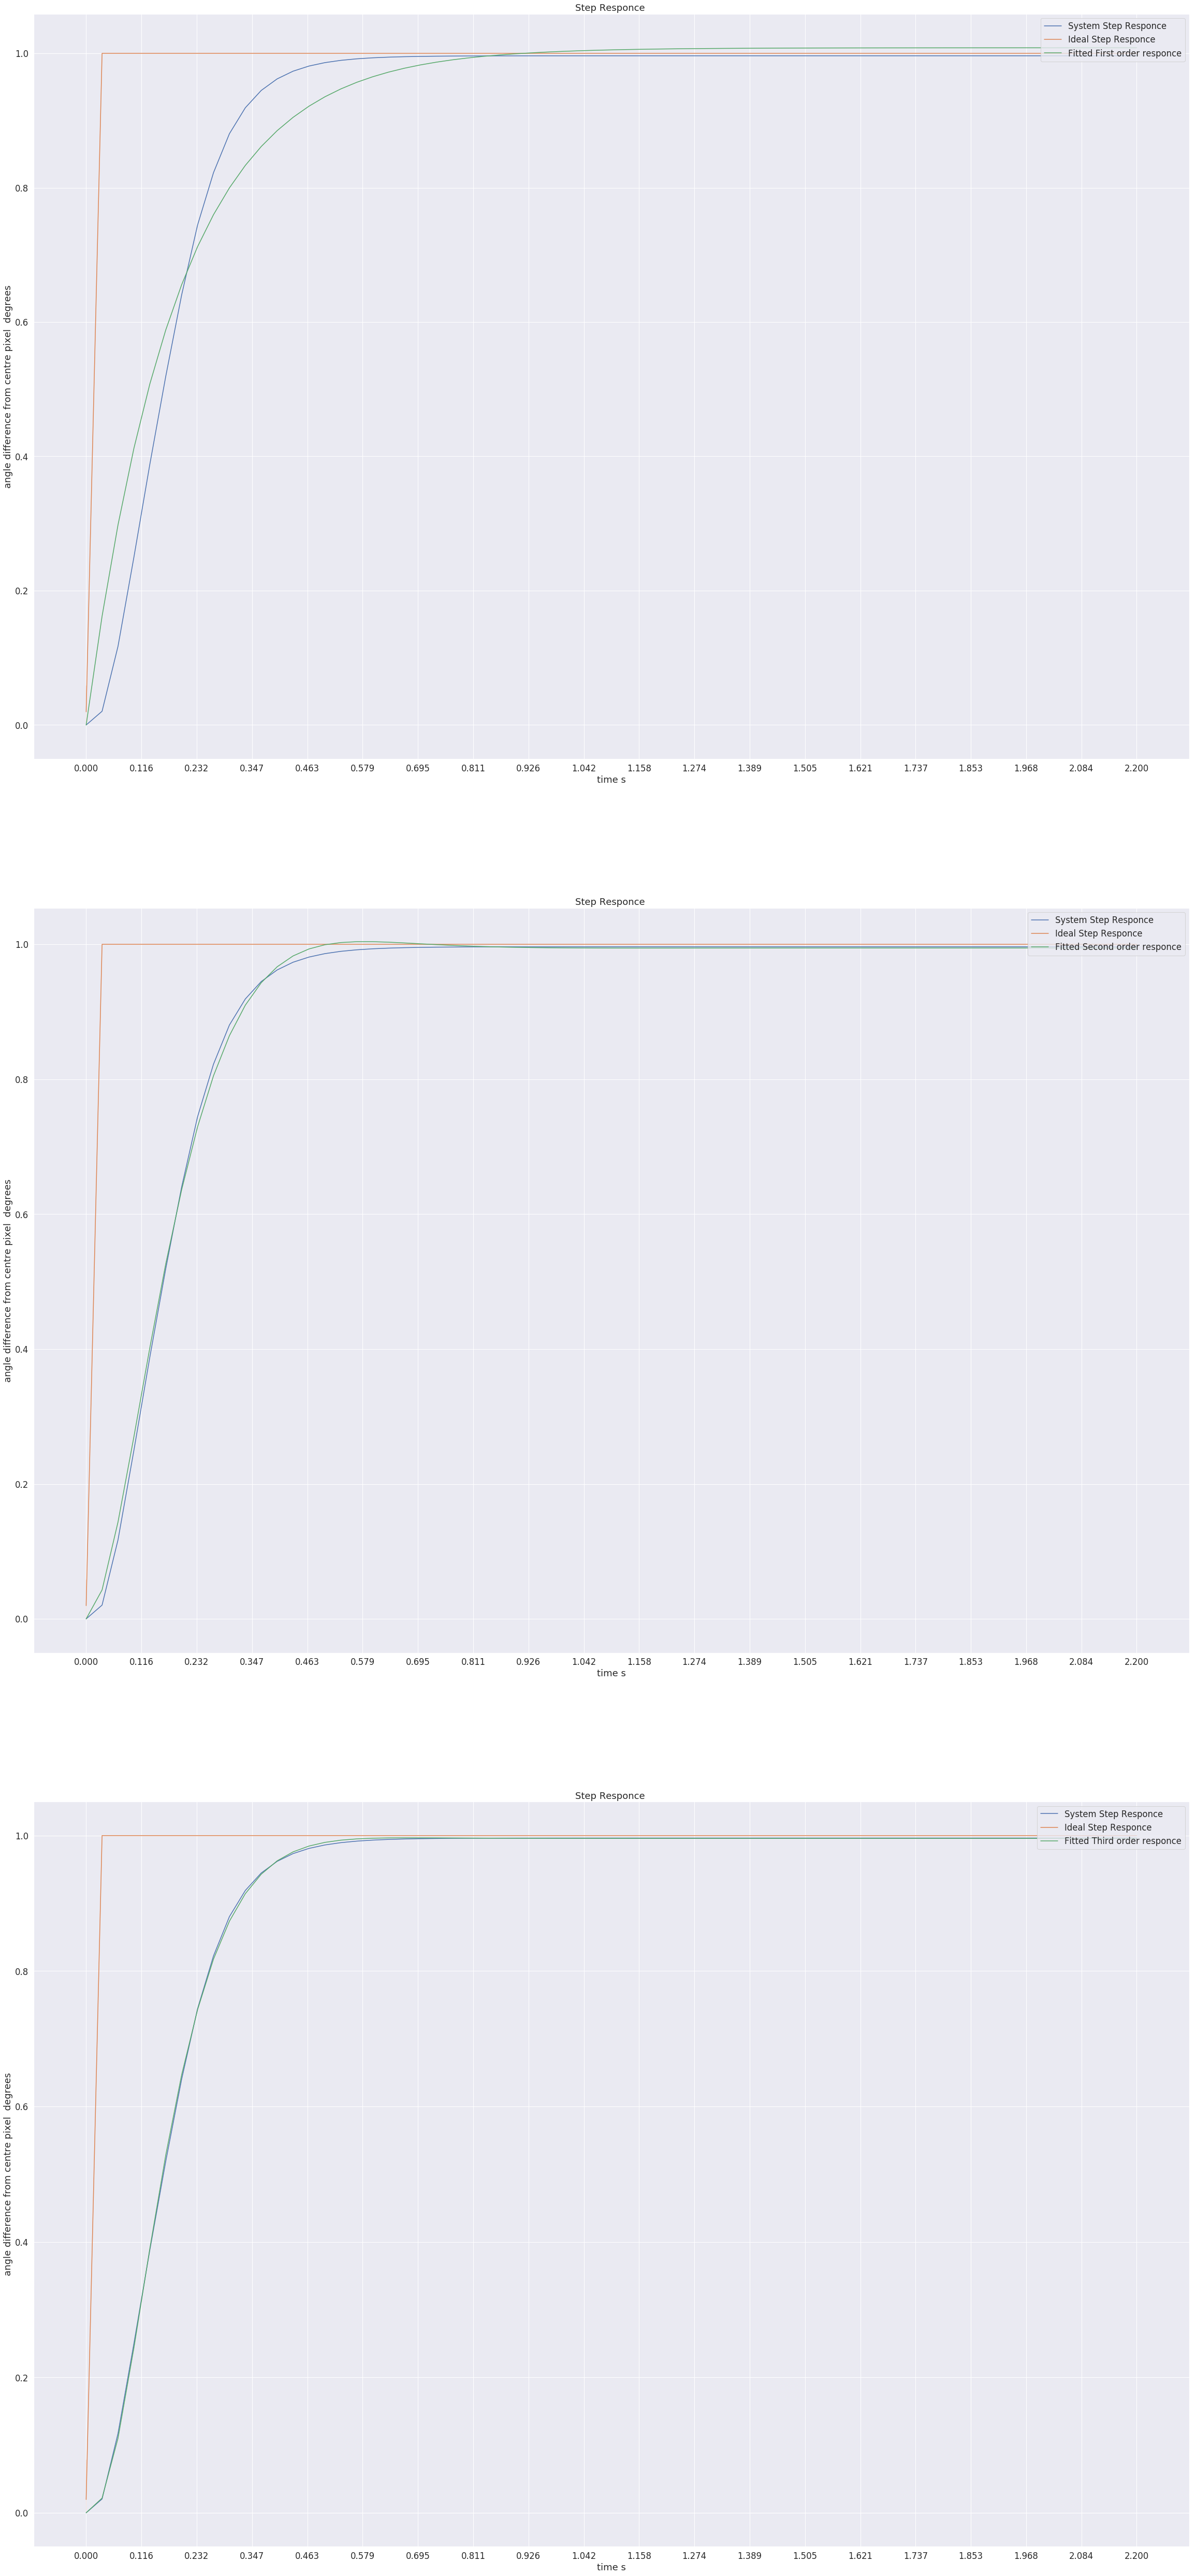

In [9]:
seaborn.set(font_scale=1.5)
plt.subplots(nrows = 3, figsize=(40,30*3))
ax = plt.subplot(3,1,1)
seaborn.lineplot(y = responce, x = time,ax=ax)
seaborn.lineplot(y = np.concatenate([[0]*50,step]), x = np.concatenate([[0]*50,time]),ax=ax)
seaborn.lineplot(y = model1(time,*par1[0]), x = time,ax=ax)
ax.set_xticks(ticks =np.linspace(time[0], time[-1],20)) 
ax.set(xlabel='time s', ylabel='angle difference from centre pixel  degrees',title = "Step Responce ")
ax.legend(['System Step Responce', 'Ideal Step Responce', 'Fitted First order responce'],loc=1)

ax = plt.subplot(3,1,2)
seaborn.set(font_scale=1.5)
seaborn.lineplot(y = responce, x = time,ax=ax)
seaborn.lineplot(y = np.concatenate([[0]*50,step]), x = np.concatenate([[0]*50,time]),ax=ax)
seaborn.lineplot(y = model2(time,*par2[0]), x = time,ax=ax)
ax.set_xticks(ticks =np.linspace(time[0], time[-1],20)) 
ax.set(xlabel='time s', ylabel='angle difference from centre pixel  degrees',title = "Step Responce ")
ax.legend(['System Step Responce', 'Ideal Step Responce', 'Fitted Second order responce'],loc=1)

ax = plt.subplot(3,1,3)
seaborn.set(font_scale=1.5)
seaborn.lineplot(y = responce, x = time,ax=ax)
seaborn.lineplot(y = np.concatenate([[0]*50,step]), x = np.concatenate([[0]*50,time]),ax=ax)
seaborn.lineplot(y = model3(time,*par3[0]), x = time,ax=ax)
ax.set_xticks(ticks =np.linspace(time[0], time[-1],20)) 
ax.set(xlabel='time s', ylabel='angle difference from centre pixel  degrees',title = "Step Responce ")
ax.legend(['System Step Responce', 'Ideal Step Responce', 'Fitted Third order responce'],loc=1);

## Arduino code Appendix
```C
#include <stdio.h>
//define motor  related pins
#define IN1 9
#define IN2 8
#define ENA 10
void setup()
{
  Serial.begin(115200); // start the serial monitor link

  //set output for motor  related pins
  pinMode(IN1, OUTPUT);
  pinMode(IN2, OUTPUT);
  pinMode(ENA, OUTPUT);

  //initialize motor 1 run in clockwise
  digitalWrite(IN1, LOW);
  digitalWrite(IN2, HIGH);
}
//#######################################################################################//
void loop()
{
    if (Serial.available() > 0) {
        int angle = Serial.read();
        angle = angle<=127? angle :angle - 256;
        if (angle<0)
            control_out(-255);
        else
            control_out(255);
        angle = abs(angle);
        delay(angle/90.0 * 212); // 212 ms makes it turn around 90 degrees
        control_out(0);
    }
}

//#######################################################################################//
int control_out(int signed_pwm)   // this function reads input(signed_pwm) ranged from (-255 to 255)
//                                   if the input is
//                                          - out of range : clip it back to range
//                                          - negative : set the output to the motor to run clockwise with the same abspolute value
//                                          - positive : set the output to the motor to run counter-clockwise with the same abspolute value
{
  if (signed_pwm > 255)
  {
    signed_pwm = 255;
  }
  if (signed_pwm < -255)
  {
    signed_pwm = -255;
  }

  if (signed_pwm > 0 )
  {
    //set motor 1 run in counter-clockwise
    digitalWrite(IN1, LOW);
    digitalWrite(IN2, HIGH);
  }

  if (signed_pwm < 0 )
  {
    //set motor 1 run in clockwise
    digitalWrite(IN1, HIGH);
    digitalWrite(IN2, LOW);

  }

  analogWrite(ENA , abs(signed_pwm));
  return (abs(signed_pwm));
}
```

## References
1: https://www.pantechsolutions.net/user-manual-technical-reference-transfer-function-of-dc-servo-motor

2: https://www.learnopencv.com/approximate-focal-length-for-webcams-and-cell-phone-cameras/